In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import SelfTrainingClassifier, LabelSpreading, LabelPropagation
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)

In [48]:
X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1200], y_digits[:1200]
X_test, y_test = X_digits[1200:], y_digits[1200:]

In [49]:
n = 30
model = LogisticRegression(max_iter=12_000)
model.fit(X_train[:n], y_train[:n])


LogisticRegression(max_iter=12000)

In [50]:
print(model.score(X_test, y_test))


0.7772194304857621


In [51]:
kmeans = KMeans(n_clusters=30, random_state=60)
X_digits = kmeans.fit_transform(X_train)
idx = np.argmin(X_digits, axis=0)
X_representative = X_train[idx]
print(y_train[idx])

[9 0 3 6 1 2 1 7 5 5 9 4 3 8 1 5 8 4 1 7 0 6 4 2 1 9 7 3 5 8]


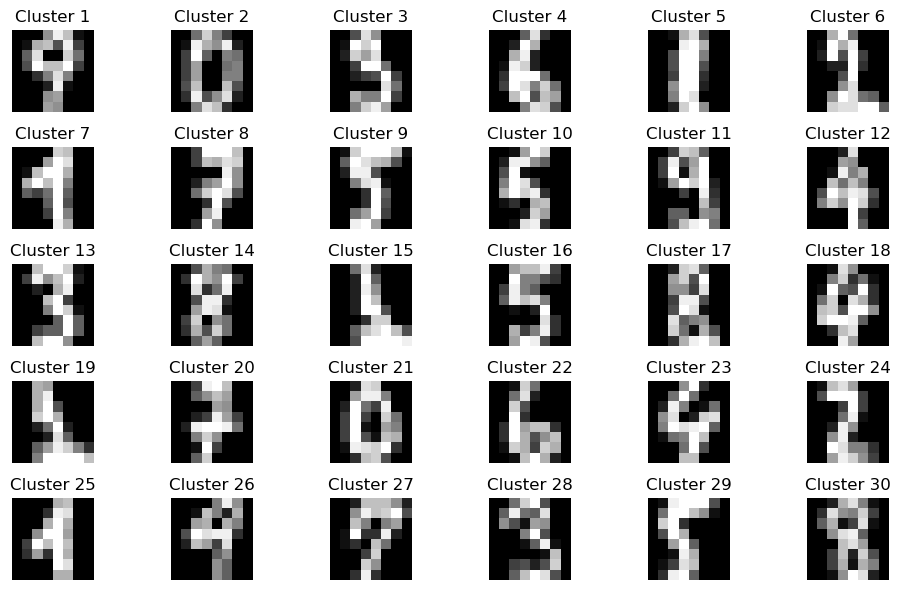

In [52]:
plt.figure(figsize=(10, 6))
for i in range(30):
    plt.subplot(5, 6, i + 1)  
    plt.imshow(X_representative[i].reshape(8, 8), cmap="gray")
    plt.axis("off")
    plt.title(f"Cluster {i+1}")
plt.tight_layout()
plt.show()

In [53]:
y_representative = np.array([
    9, 0, 3, 6, 1, 2, 1, 7, 5, 5, 9, 4, 3, 8, 1, 5, 8, 4, 1, 7, 
    0, 6, 4, 2, 1, 9, 7, 3, 5, 8
])

In [54]:
model = LogisticRegression(max_iter=12_000)
model.fit(X_representative, y_representative)
model.score(X_test, y_test)

0.8324958123953099

In [55]:
y_propagated = np.empty(len(X_train), dtype=np.int64)
for i in range(30):
 y_propagated[kmeans.labels_ == i] = y_representative[i]

In [56]:
model = LogisticRegression(max_iter=12_000)
model.fit(X_train, y_propagated)
baseline_score = model.score(X_test, y_test)

In [57]:
label_spread = LabelSpreading(kernel='knn')
label_spread.fit(X_train, y_propagated)
label_spread_score = label_spread.score(X_test, y_test)


In [58]:
label_prop = LabelPropagation(kernel='knn')
label_prop.fit(X_train, y_propagated)
label_prop_score = label_prop.score(X_test, y_test)

In [59]:
print(f"LabelSpreading Accuracy: {label_spread_score}")
print(f"LabelPropagation Accuracy: {label_prop_score}")

LabelSpreading Accuracy: 0.9547738693467337
LabelPropagation Accuracy: 0.9547738693467337


In [60]:
rf = RandomForestClassifier(n_estimators=100, random_state=60)
self_training_clf = SelfTrainingClassifier(rf)

self_training_clf.fit(X_train, y_propagated)
self_training_score = self_training_clf.score(X_test, y_test)

print(f"SelfTrainingClassifier Accuracy: {self_training_score}")

C:\Users\marce\anaconda4\Lib\site-packages\sklearn\semi_supervised\_self_training.py:227: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


SelfTrainingClassifier Accuracy: 0.9363484087102177


In [61]:
print(f"Baseline Logistic Regression Accuracy: {baseline_score}")
print(f"LabelSpreading Accuracy: {label_spread_score}")
print(f"LabelPropagation Accuracy: {label_prop_score}")
print(f"SelfTrainingClassifier Accuracy: {self_training_score}")


Baseline Logistic Regression Accuracy: 0.8961474036850922
LabelSpreading Accuracy: 0.9547738693467337
LabelPropagation Accuracy: 0.9547738693467337
SelfTrainingClassifier Accuracy: 0.9363484087102177


In [64]:
def active_learning(X_train, y_train, X_test, y_test, model, n_rounds=10, n_instances=10):
    labeled_indices = np.arange(30)
    unlabeled_indices = np.setdiff1d(np.arange(len(X_train)), labeled_indices)
    
    for round_num in range(n_rounds):
        model.fit(X_train[labeled_indices], y_train[labeled_indices])
        
        probs = model.predict_proba(X_train[unlabeled_indices])
        uncertainty = 1 - np.max(probs, axis=1)
        
        uncertain_idx = np.argsort(uncertainty)[-n_instances:]
        selected_indices = unlabeled_indices[uncertain_idx]
        
        print(f"Round {round_num + 1}: Instances selected for labeling: {selected_indices}")
        
        new_labels = y_train[selected_indices]
        
        labeled_indices = np.concatenate([labeled_indices, selected_indices])
        y_train[selected_indices] = new_labels
        
        unlabeled_indices = np.setdiff1d(unlabeled_indices, selected_indices)
        
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        print(f"Test accuracy after round {round_num + 1}: {score:.4f}")
    
    return model



In [65]:
model = active_learning(X_train, y_train, X_test, y_test, model)

Round 1: Instances selected for labeling: [ 972  400  657  814  274 1068  540  638  899  264]
Test accuracy after round 1: 0.7772
Round 2: Instances selected for labeling: [561 738 771 898 551 720 151 985 381 409]
Test accuracy after round 2: 0.7856
Round 3: Instances selected for labeling: [ 417  459 1037 1146  744  906  832  583 1149  782]
Test accuracy after round 3: 0.7990
Round 4: Instances selected for labeling: [ 430  617  204  447  438 1162  187  125  494  429]
Test accuracy after round 4: 0.8157
Round 5: Instances selected for labeling: [ 762  678  827   54  209   77  364  808  355 1091]
Test accuracy after round 5: 0.8358
Round 6: Instances selected for labeling: [ 158  420  348   92 1095  363  480  384 1078  103]
Test accuracy after round 6: 0.8744
Round 7: Instances selected for labeling: [ 421  891  446  579  341  784 1108  670  198  449]
Test accuracy after round 7: 0.8643
Round 8: Instances selected for labeling: [816 578 804 710 940 511 568 361 211 751]
Test accuracy af